In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna

import warnings
warnings.filterwarnings("ignore")

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
train = pd.read_csv('train.csv')
test = pd.read_csv('train.csv')
sub = pd.read_csv('sample_submission.csv')

In [28]:
train.dtypes

Id                         int64
Make                      object
Vehicle Class             object
Engine Size(L)            object
Cylinders                 object
Transmission              object
Fuel Type                 object
Fuel Consumption City     object
Fuel Consumption Hwy      object
Fuel Consumption Comb     object
CO2 Emissions(g/km)      float64
dtype: object

In [29]:
def hapus_satuan(df, col):
    df[col] = df[col].str.replace(' ', '')
    df[col] = df[col].str.replace('litersper100km', '')
    df[col] = df[col].str.replace('L/100km', '')
    df[col] = df[col].str.replace('L/10km', '')
    df[col] = df[col].str.replace('MPG(AS)', '')
    df[col] = df[col].str.replace('km/L', '')
    df[col] = df[col].str.replace('kmperL', '')
    df[col] = df[col].str.replace('mpgImp.', '')
    df[col] = df[col].str.replace('not-available', '-1')
    df[col] = df[col].str.replace('zero', '0')
    df[col] = df[col].astype(float)

In [42]:
def change(df, col):
    df[col] = df[col].str.replace(' ', '')
    df[col] = df[col].str.replace('litersper100km', '')
    df[col] = df[col].str.replace('L/100km', '')
    df[col] = df[col].str.replace('L/10km', '*10')#'/10')
    df[col] = df[col].str.replace('MPG(AS)', '**(-1)* 235.21')
    df[col] = df[col].str.replace('km/L', '')#**(-1) /100')
    df[col] = df[col].str.replace('kmperL', '')#'**(-1) /100')
    df[col] = df[col].str.replace('mpgImp.', '**(-1)* 282.48')
    df[col] = df[col].str.replace('not-available', '-1')
    df[col] = df[col].str.replace('zero', '0')
    df[col] = df[col].fillna("-1")
    for idx in df.index:
        df.at[idx, col] = eval(df.at[idx, col])
    df[col] = df[col].astype(float)
    df[col].values[df[col] > 100] = np.nan
    df[col].values[df[col] < 0] = np.nan

In [43]:
change(train, 'Fuel Consumption City')

In [55]:
def IQR(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    return [q1-1.5*iqr, q3+1.5*iqr]

In [56]:
IQR(train, 'Fuel Consumption City')

[-14.480000000000008, 38.96000000000001]

In [58]:
train['Fuel Consumption City'].values[train['Fuel Consumption City'] > 38.96] = np.nan

<Axes: xlabel='Fuel Consumption City'>

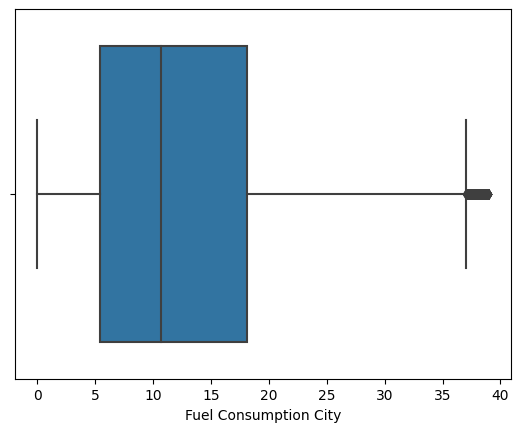

In [60]:
sns.boxplot(x=train['Fuel Consumption City'])

In [62]:
train['Fuel Consumption City'].isnull().sum()

9799

In [59]:
train['Fuel Consumption City'].describe()

count    127342.000000
mean         12.443939
std           8.619295
min           0.000000
25%           5.440000
50%          10.667120
75%          18.084507
max          38.950000
Name: Fuel Consumption City, dtype: float64

<Axes: >

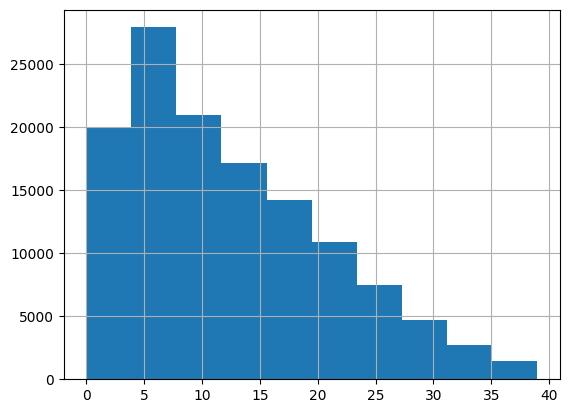

In [69]:
train['Fuel Consumption City'].hist()

In [47]:
train

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km)
0,1,FOLD,PICKUP TRUCK - STANDARD,3.5,6.0,A6,X,8.64,6.14 L/100 km,37.59 mpg Imp.,306.0
1,2,CHEVO,PICKUP TRUCK - STANDARD,5.3,NaN,A6,E,27.27,30.76 liters per 100 km,28.84 L/100 km,283.0
2,3,BMV,SUBCOMPACT,4.4,NaN,M6,Z,1.70,2.03 liters per 100 km,zero,329.0
3,4,KIO,SUV - SMALL,NaN,4.0,AS6,X,6.52,1.59 L/10km,NaN,270.0
4,5,BARUSU,MINICOMPACT,3.0,6.0,unspecified,Z,20.15,0.60 L/10km,1.38 L/10km,193.0
...,...,...,...,...,...,...,...,...,...,...,...
137136,137137,BMV,SUBCOMPACT,na,8.0,AS8,Z,33.71,12.99 km per L,4.54 km per L,275.0
137137,137138,GONDA,STATION WAGON - SMALL,1.5,4.0,M6,X,15.41,0.87 L/100 km,59.38 MPG (AS),166.0
137138,137139,NIRRAN,MID-SIZE,1.8,4.0,AV,X,2.99,8.38 L/100 km,52.19 mpg Imp.,181.0
137139,137140,TOYOTI,COMPACT,1.8,4.0,na,X,11.48,1275.84 mpg Imp.,0.64 L/10km,123.0


In [32]:
train['Fuel Consumption City'].describe()

count    132331.000000
mean          8.678202
std          10.360087
min           0.000000
25%           0.003226
50%           4.837815
75%          15.113965
max          88.630000
Name: Fuel Consumption City, dtype: float64

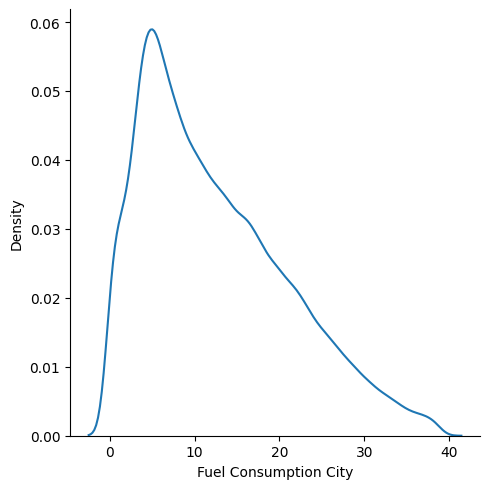

In [68]:
sns.displot(train, x='Fuel Consumption City', kind='kde')

<Axes: xlabel='Fuel Consumption City'>

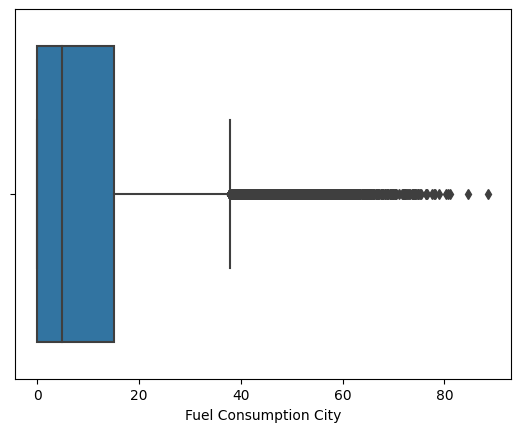

In [37]:
sns.boxplot(x=train['Fuel Consumption City'])

In [38]:
train[train['Fuel Consumption City'] > 40]

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km)
5,6,LECUS,COMPACT,unspecified,4.0,not-recorded,Z,42.228007,38.28 mpg Imp.,8.86 MPG (AS),217.0
38,39,FIAR,SUV - SMALL,1.3,4.0,A9,X,56.496000,11.29 liters per 100 km,7.81 mpg Imp.,206.0
50,51,LECUS,SUBCOMPACT,3.5,6.0,AS6,Z,58.364764,-9999,5.69 MPG (AS),259.0
176,177,CADILUXE,FULL-SIZE,2.0,4.0,not-available,Z,54.110000,644.92 km per L,29.83 L/100 km,217.0
542,543,TOYOTI,MID-SIZE,3.5,6.0,AS8,X,51.820000,11.24 L/100km,33.56 L/100 km,224.0
...,...,...,...,...,...,...,...,...,...,...,...
136985,136986,BMV,MID-SIZE,4.4,8.0,AS8,Z,51.520000,23.84 mpg Imp.,2.97 km/L,301.0
137027,137028,KIO,COMPACT,2.8,4.0,M6,X,50.989170,20.20 MPG (AS),33.27 L/100 km,199.0
137050,137051,BMV,STATION WAGON - SMALL,2.0,4.0,A8,NaN,42.170000,32.95 mpg Imp.,3.70 km/L,179.0
137080,137081,TOYOTI,PICKUP TRUCK - STANDARD,4.6,unknown,AS6,X,43.659969,zero,37.19 L/100km,431.0


In [36]:
train['Fuel Consumption City'].isnull().sum()

4810

In [25]:
train[(train['Fuel Consumption City'] > 80) & (train['Fuel Consumption City'] != 9999)]

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km)
30838,30839,FOLD,FULL-SIZE,3.5,6.0,AS6,X,84.574850,6.19 km/L,1.86 km/L,291.0
40923,40924,FOLD,VAN - PASSENGER,4.6,8.0,A4,X,80.708571,1.52 L/100km,45.05 L/100km,361.0
64717,64718,TOYOTI,MINIVAN,3.5,6.0,AS8,X,88.630000,0,1.83 km/L,270.0
84613,84614,NIRRAN,unknown,3.7,6.0,M6,Z,81.172414,7.04 km per L,51.09 liters per 100 km,267.0
119204,119205,KIO,SUV - SMALL,2.4,4.0,M6,X,80.230000,24.72 MPG (AS),2.07 km per L,258.0


In [15]:
train[train['Fuel Consumption City'] == 9999]

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km)
172,173,NIRRAN,SUV - SMALL,2.5,4.0,AV,X,9999.0,3.84 liters per 100 km,4.92 L/100km,189.0
240,241,JIPU,SUV - SMALL,3.6,not-recorded,A5,X,9999.0,7.61 km per L,8.33 km per L,335.0
450,451,FOLD,MID-SIZE,2.0,4.0,M6,X,9999.0,28.98 liters per 100 km,2.04 L/10km,223.0
484,485,NIRRAN,STATION WAGON - SMALL,NaN,4.0,M6,Z,9999.0,8.90 L/100km,4.22 km per L,194.0
697,698,CHEVO,STATION WAGON - SMALL,NaN,4.0,M5,not-available,9999.0,19.46 km per L,8.71 L/100km,200.0
...,...,...,...,...,...,...,...,...,...,...,...
136269,136270,LECUS,SUBCOMPACT,3.5,6.0,AS6,Z,9999.0,13.40 MPG (AS),16.00 liters per 100 km,281.0
136838,136839,KIO,MID-SIZE,2.0,4.0,A6,X,9999.0,14.41 MPG (AS),5.89 km per L,216.0
136984,136985,CHEVO,PICKUP TRUCK - STANDARD,NaN,8.0,A6,Z,9999.0,11.58 MPG (AS),4.88 km per L,349.0
137046,137047,JIPU,SUV - STANDARD,NaN,NaN,A8,X,9999.0,22.53 L/100 km,30.18 liters per 100 km,476.0


In [ ]:
change(train, 'Fuel Consumption Hwy')

In [ ]:
change(train, 'Fuel Consumption Comb')

In [59]:
hapus_satuan(train, 'Fuel Consumption City')

In [76]:
train['Fuel Consumption City'].describe()

count    132284.000000
mean         29.457345
std         175.644367
min           0.000000
25%           4.600000
50%          11.090000
75%          20.882500
max        9840.550000
Name: Fuel Consumption City, dtype: float64

In [ ]:
[print(x) for x in train['Fuel Consumption City']]

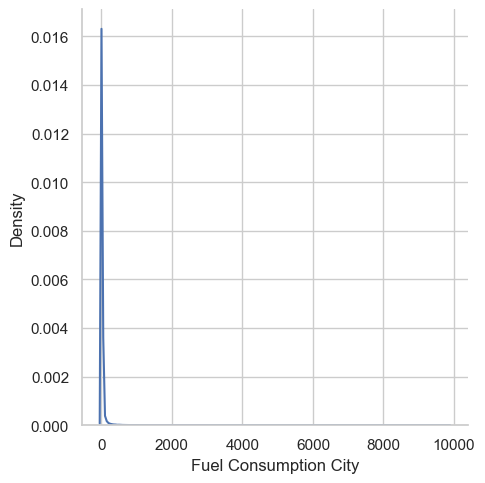

In [73]:
sns.displot(train, x="Fuel Consumption City", kind="kde")

In [ ]:
train[train['Fuel Consumption City'] == -1]['Fuel Consumption City'] = np.nan

In [69]:
train = train.replace(-1.0, np.nan)
train['Fuel Consumption City'].values[train['Fuel Consumption City'] >= 9999] = np.nan
train['Fuel Consumption City'].values[train['Fuel Consumption City'] < 0] = np.nan

In [64]:
train

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km)
0,1,FOLD,PICKUP TRUCK - STANDARD,3.5,6.0,A6,X,8.64,6.14 L/100 km,37.59 mpg Imp.,306.0
1,2,CHEVO,PICKUP TRUCK - STANDARD,5.3,NaN,A6,E,27.27,30.76 liters per 100 km,28.84 L/100 km,283.0
2,3,BMV,SUBCOMPACT,4.4,NaN,M6,Z,0.17,2.03 liters per 100 km,zero,329.0
3,4,KIO,SUV - SMALL,NaN,4.0,AS6,X,6.52,1.59 L/10km,NaN,270.0
4,5,BARUSU,MINICOMPACT,3.0,6.0,unspecified,Z,20.15,0.60 L/10km,1.38 L/10km,193.0
...,...,...,...,...,...,...,...,...,...,...,...
137136,137137,BMV,SUBCOMPACT,na,8.0,AS8,Z,33.71,12.99 km per L,4.54 km per L,275.0
137137,137138,GONDA,STATION WAGON - SMALL,1.5,4.0,M6,X,15.41,0.87 L/100 km,59.38 MPG (AS),166.0
137138,137139,NIRRAN,MID-SIZE,1.8,4.0,AV,X,2.99,8.38 L/100 km,52.19 mpg Imp.,181.0
137139,137140,TOYOTI,COMPACT,1.8,4.0,na,X,11.48,1275.84 mpg Imp.,0.64 L/10km,123.0


In [68]:
train[train['Fuel Consumption City'] < 0]

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km)
93,94,JIPU,SUV - SMALL,2.4,4.0,A9,NaN,-9999.0,15.37 L/100km,13.17 liters per 100 km,225.0
139,140,TOYOTI,SUV - STANDARD,2.4,4.0,AS5,X,-9999.0,14.48 MPG (AS),17.91 MPG (AS),334.0
156,157,LECUS,MID-SIZE,5.0,8.0,na,Z,-9999.0,9999,2.92 km/L,278.0
374,375,TOYOTI,MINICOMPACT,2.0,4.0,M6,NaN,-9999.0,9.55 MPG (AS),1.29 L/10km,236.0
493,494,DOGE,MID-SIZE,5.0,8.0,M6,X,-9999.0,3.73 liters per 100 km,30.38 km per L,208.0
...,...,...,...,...,...,...,...,...,...,...,...
135423,135424,RYUNDAI,SUV - SMALL,3.3,6.0,AS6,X,-9999.0,17.00 mpg Imp.,6.89 km/L,262.0
135491,135492,TOYOTI,STATION WAGON - SMALL,1.8,not-available,A4,X,-9999.0,48.14 mpg Imp.,7.19 L/100 km,189.0
135681,135682,GONDA,FULL-SIZE,2.0,4.0,M6,X,-9999.0,253.92 MPG (AS),26.18 MPG (AS),175.0
135714,135715,FOLD,SUV - STANDARD,NaN,4.0,A6,X,-9999.0,15.19 L/100km,22.19 MPG (AS),229.0


In [75]:
train[train['Fuel Consumption City'] > 200]

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km)
78,79,BMV,SUV - STANDARD,3.0,6.0,AS8,Z,200.24,9.29 L/100km,20.71 km/L,280.000000
177,178,FOLD,SPECIAL PURPOSE VEHICLE,2.5,4.0,AS6,X,4541.75,1.05 L/10km,4.75 L/100km,237.000000
331,332,FOLKSWA,COMPACT,NaN,4.0,AM6,Z,465.34,870.84 km per L,259.40 km/L,552.204136
387,388,TOLVO,SUV - SMALL,2.0,4.0,AS8,Z,371.10,8.20 liters per 100 km,4.04 liters per 100 km,216.000000
423,424,NIRRAN,MID-SIZE,3.5,6.0,AV7,X,393.57,13.88 L/100 km,6.64 liters per 100 km,206.000000
...,...,...,...,...,...,...,...,...,...,...,...
136707,136708,GONDA,MID-SIZE,4.4,8.0,A6,X,401.42,22.08 MPG (AS),5.12 L/100km,210.000000
136756,136757,FIAR,SUV - SMALL,1.4,4.0,M6,X,340.65,7.66 km per L,6.26 liters per 100 km,193.000000
136767,136768,CHEVO,SUV - SMALL,2.5,4.0,A9,X,776.44,17.26 L/100km,35.46 mpg Imp.,240.000000
136861,136862,FOLD,PICKUP TRUCK - STANDARD,3.5,NaN,AS10,X,208.01,35.82 km per L,49.92 km/L,288.000000


In [72]:
train['Fuel Consumption City'].describe()

count    132284.000000
mean         29.457345
std         175.644367
min           0.000000
25%           4.600000
50%          11.090000
75%          20.882500
max        9840.550000
Name: Fuel Consumption City, dtype: float64